<a href="https://colab.research.google.com/github/Wiaz24/LSTM/blob/main/ProjektNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import torch
import torch.nn as nn
import pandas_datareader as web
import datetime as dt
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from pathlib import Path
from tqdm import tqdm
import os
print(torch.__version__)

2.0.0+cu118


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir datasets

In [4]:
!cp drive/MyDrive/LunarData.csv datasets/LunarData.csv

### Hyprparameters

In [22]:
num_epochs = 100
learning_rate = 0.0005
train_perc = 0.60
batch_size = 32

input_size = 14
hidden_size = 256
num_lstm_layers = 3

seq_length = 60
pred_length = 4

### Download or load dataset

In [6]:
DATASETS_PATH = Path("datasets")
DATASETS_PATH.mkdir(parents=True, exist_ok=True)

DATASET_NAME = "LunarData.csv"
#DATASET_NAME = "BTC_USD.csv"
DATASET_SAVE_PATH = DATASETS_PATH / DATASET_NAME

alldata = pd.read_csv(DATASET_SAVE_PATH)
  
# start = dt.datetime(2017, 1, 1)
# end = dt.datetime.now()
# alldata = yf.download('BTC-USD', start=start, end=end, progress=False)
# print(f"Saving dataset to: {DATASET_SAVE_PATH}")
# alldata.to_csv(DATASET_SAVE_PATH, index=False)

### Data plot

(Num of examples, number of attributes) = (19272, 14)
[[8.38384380e+03 8.31591237e+03 6.65000000e+01 1.74000000e+02
  5.00000000e+00 1.88000000e+03 3.03961196e+01 3.70000000e+00
  8.26000000e+02 1.24000000e+03 1.97000000e+02 2.00000000e+00
  6.70115727e+01 2.80875800e-02]
 [8.39858668e+03 8.43240018e+03 6.50000000e+01 1.90000000e+02
  5.00000000e+00 1.61700000e+03 2.90931990e+01 3.70000000e+00
  6.63000000e+02 1.09200000e+03 1.47000000e+02 1.00000000e+00
  6.74648161e+01 2.86838800e-02]
 [8.51384077e+03 8.34855467e+03 6.90000000e+01 1.73000000e+02
  5.00000000e+00 1.91300000e+03 3.18780203e+01 3.60000000e+00
  7.16000000e+02 1.33600000e+03 2.31000000e+02 1.00000000e+00
  6.72991887e+01 2.97688200e-02]]


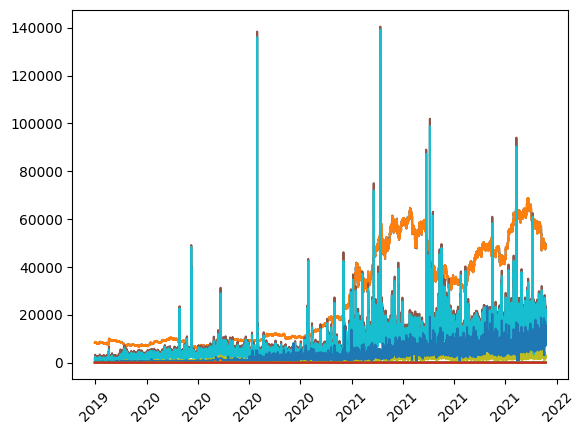

In [7]:
dates = pd.to_datetime(alldata['time'], unit='s')
data = alldata.iloc[:, :-1].to_numpy()

print(f"(Num of examples, number of attributes) = {data.shape}")
date_form = DateFormatter("%Y")
_dates = dates
fig, ax = plt.subplots()
ax.plot(_dates, data)
ax.xaxis.set_major_formatter(date_form)
# Rotacja etykiet osi X
plt.xticks(rotation=45)
print(data[0:3,:])
plt.show()

## Dataloading

In [8]:
data[:,1].reshape(-1,1).shape

(19272, 1)

In [9]:
def sliding_windows(data, seq_length=1):
    x = []
    y = []

    # przykładowo: seq_lenght = 7, pred_length = 3, wtedy:
    for i in range(0, len(data) - seq_length - pred_length, pred_length):  # dla i = 0:
        _x = data[i:(i+seq_length), :]                      # _x = data[0:7, wszystkie cechy],  potem data[3:10,:]
        _y = data[i+seq_length:i+seq_length+pred_length, 1] # _y = data[7:10, close_price] ,    potem data[10:13,1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
outSc = MinMaxScaler()
outSc.fit_transform(data[:,1].reshape(-1,1))
data = sc.fit_transform(data) #normalizacja danych
x, y = sliding_windows(data, seq_length)  #tworzenie ramek uczących i odpowiedzi

print(f"x.shape = {x.shape}, y.shape = {y.shape}")                

x.shape = (4802, 60, 14), y.shape = (4802, 4)


In [10]:
train_size = int(len(y) * train_perc)
test_size = int((len(y) - train_size)/2)
eval_size = test_size

device = "cuda" if torch.cuda.is_available() else "cpu"

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))
dataX = dataX.to(device)
dataY = dataY.to(device)

trainDataLoader

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
trainX = trainX.to(device)
trainY = trainY.to(device)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
testX = testX.to(device)
testY = testY.to(device)

In [11]:
print(f"trainX.shape = {trainX.shape}, trainY.shape = {trainY.shape}")
print(f"testX.shape = {testX.shape}, testY.shape = {testY.shape}")

trainX.shape = torch.Size([3217, 60, 14]), trainY.shape = torch.Size([3217, 4])
testX.shape = torch.Size([1585, 60, 14]), testY.shape = torch.Size([1585, 4])


In [12]:
trainX.device, testY.device

(device(type='cuda', index=0), device(type='cuda', index=0))

## Model

In [13]:
class LSTM(nn.Module):

    def __init__(self, pred_length, input_size, hidden_size, num_lstm_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = pred_length
        self.num_lstm_layers = num_lstm_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_lstm_layers, x.size(0), self.hidden_size).cuda())

        c_0 = Variable(torch.zeros(
            self.num_lstm_layers, x.size(0), self.hidden_size).cuda())

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        # Reshape for dense layer
        out = output[:, -1, :]
        
        out = self.fc(out)
        
        return out

## Training

In [23]:
%%time

lstm = LSTM(pred_length, input_size, hidden_size, num_lstm_layers)
lstm.to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

first = True

# Train the model
for epoch in tqdm(range(num_epochs)):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    if first == True:
      print(outputs.shape)
      first = False
    # obtain the loss function
    
    trainY = trainY.reshape(-1, pred_length)
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()))

print(outputs.shape)
print(trainY.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([3217, 4])


  1%|          | 1/100 [00:00<00:59,  1.65it/s]

Epoch: 0, loss: 0.07039738


 11%|█         | 11/100 [00:06<01:04,  1.37it/s]

Epoch: 10, loss: 0.03802961


 21%|██        | 21/100 [00:12<00:58,  1.35it/s]

Epoch: 20, loss: 0.02114635


 31%|███       | 31/100 [00:17<00:51,  1.33it/s]

Epoch: 30, loss: 0.00607643


 41%|████      | 41/100 [00:23<00:45,  1.29it/s]

Epoch: 40, loss: 0.00179907


 51%|█████     | 51/100 [00:29<00:37,  1.30it/s]

Epoch: 50, loss: 0.00091689


 61%|██████    | 61/100 [00:36<00:30,  1.28it/s]

Epoch: 60, loss: 0.00048036


 71%|███████   | 71/100 [00:42<00:22,  1.27it/s]

Epoch: 70, loss: 0.00035636


 81%|████████  | 81/100 [00:48<00:15,  1.27it/s]

Epoch: 80, loss: 0.00027128


 91%|█████████ | 91/100 [00:54<00:07,  1.25it/s]

Epoch: 90, loss: 0.00022197


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]

torch.Size([3217, 4])
torch.Size([3217, 4])
CPU times: user 58.9 s, sys: 138 ms, total: 59 s
Wall time: 59.6 s


# Testing

In [24]:
lstm.eval()
with torch.inference_mode():
  predictions = lstm(dataX)
predictions = predictions.to('cpu')
dataY = dataY.to('cpu')

In [25]:
predictions.shape, dataY.shape

(torch.Size([4802, 4]), torch.Size([4802, 4]))

In [26]:
loss = criterion(predictions, dataY)
print(f"Loss = {loss}")

Loss = 0.000987604376859963


In [27]:
predictions_np = predictions.reshape(-1,1).data.numpy()
dataY_np = dataY.reshape(-1,1).data.numpy()

In [28]:
predictions_np.shape, dataY_np.shape

((19208, 1), (19208, 1))

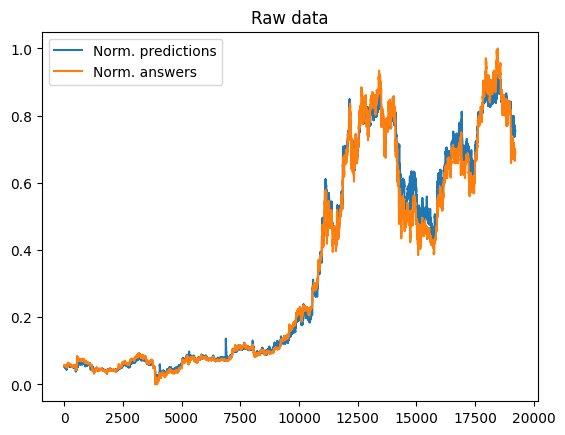

In [29]:
plt.plot(predictions_np, label="Norm. predictions")
plt.plot(dataY_np, label="Norm. answers")
plt.legend()
plt.title("Raw data")
plt.show()

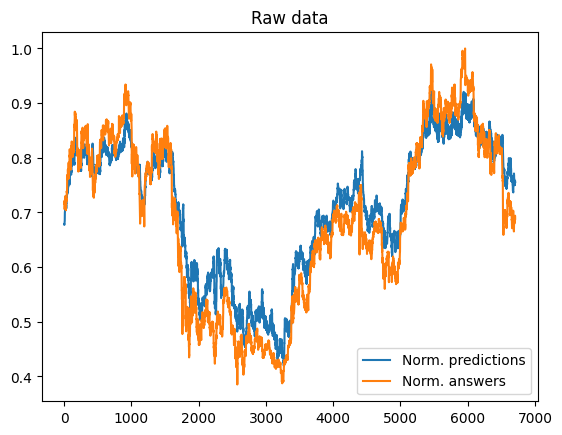

In [30]:
plt.plot(predictions_np[12500:], label="Norm. predictions")
plt.plot(dataY_np[12500:], label="Norm. answers")
plt.legend()
plt.title("Raw data")
plt.show()

In [31]:
dataY_np_unorm = outSc.inverse_transform(dataY_np)
predictions_np_unorm = outSc.inverse_transform(predictions_np)

In [32]:
dataY_np_unorm[:3], dataY_np[:3]

(array([[8227.601],
        [8223.103],
        [8191.513]], dtype=float32),
 array([[0.05727246],
        [0.05720252],
        [0.05671121]], dtype=float32))

In [33]:
_dates = dates[seq_length : seq_length+dataY_np.size]
print(_dates.size)

19208


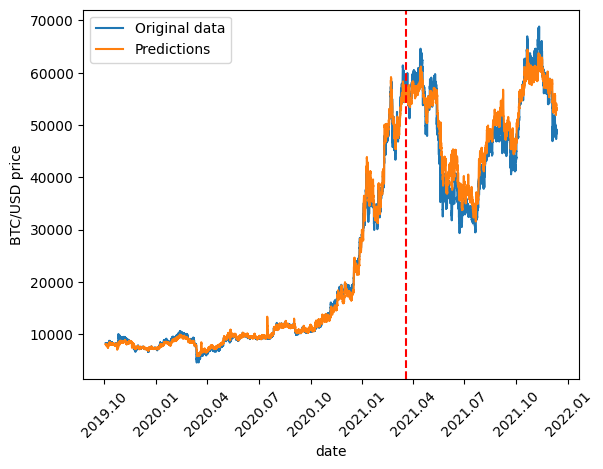

In [34]:
# Tworzenie wykresu
fig, ax = plt.subplots()
ax.plot(_dates, dataY_np_unorm, label="Original data")
ax.plot(_dates, predictions_np_unorm, label="Predictions")
ax.axvline(x=_dates[int(dataY_np.size*train_perc)], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()

# plt.plot(predictions_np_unorm, label="predictions")
# plt.plot(dataY_np_unorm, label="answers")
# plt.legend()
# plt.title("Predicted data")
# plt.show()

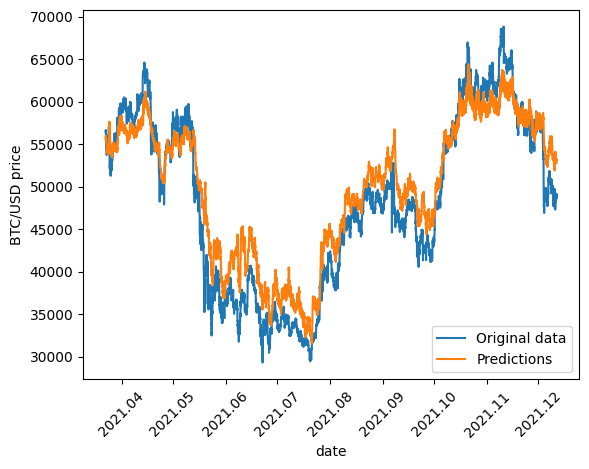

In [35]:
# Tworzenie wykresu
fig, ax = plt.subplots()
startInd = int(_dates.size*train_perc)
ax.plot(_dates[startInd:], dataY_np_unorm[startInd:], label="Original data")
ax.plot(_dates[startInd:], predictions_np_unorm[startInd:], label="Predictions")
#ax.axvline(x=dates[train_size], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()

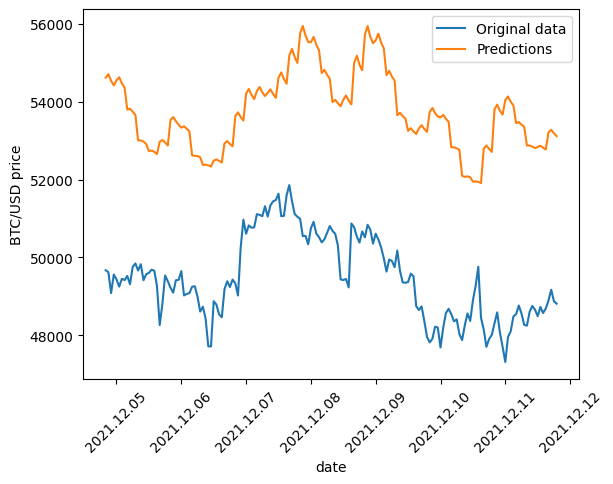

In [36]:
# Tworzenie wykresu
fig, ax = plt.subplots()
startInd = int(_dates.size*train_perc)
ax.plot(_dates[-168:], dataY_np_unorm[-168:], label="Original data")
ax.plot(_dates[-168:], predictions_np_unorm[-168:], label="Predictions")
#ax.axvline(x=dates[train_size], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m.%d")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()